# A tutorial in torchAttacks (Adversarial attacks)
Here I have followed the following [example](https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118) for a convolution neural network.

However I followed this [tutorial](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html) for the adversarial attack stuff.

## Import.STONKS()

And also check whether the GPU is available

In [51]:
from __future__ import print_function
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from random import randint


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cpu device


## Inputs

We apparently only need three inputs for this model. They are:

- **Epsilons** A list of epsilon values in the range [0,1]. Importantly 0 has to be kept in the list as it has to represent the model performance on the original test set.
- **pretrained_model** The path to a pretrained model. (because we lazy).
- **use_cuda** Just a boolean to tell the model to use a GPU if available (which it isn't on this computer...)

In [2]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "data/lenet_mnist_model.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Downloading data

Downloading a big library of data!

In [3]:
train_data = datasets.MNIST(
    root = 'data_MNIST_numbies',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)

test_data = datasets.MNIST(
    root = 'data_MNIST_numbies', 
    train = False, 
    transform = ToTensor()
)


### How does our training set look?

We plot an example from our dataset

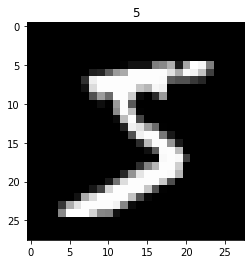

In [4]:
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()


We can also plot multiple images from our training set... wauv

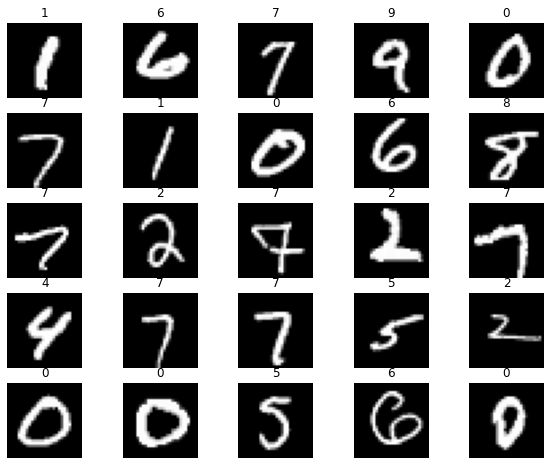

In [5]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Preparing data for training

Our training data needs to prepped for the network, this is easily accomplished with the dataloaders.

In [6]:
loaders = {
    'train' : torch.utils.data.DataLoader(
        train_data, 
        batch_size=1, 
        shuffle=True, 
        num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(
        test_data, 
        batch_size=1, 
        shuffle=True, 
        num_workers=1),
}

## Model under attack

The model obviously also needs to be defined:

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size = 2),    
        )
          
        self.conv2 = nn.Sequential(            
            nn.Conv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),  
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size = 2),                
        )
        
        # fully connected layer, output 10 classes
        ## TODO: 4 * 4 was changed from 7 * 7, as a test
        self.out = nn.Linear(32 * 7 * 7, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output   #, x    # return x for visualization

# Initialize the network
model = CNN().to(device)

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)

## Defining loss and optimization function

Both the loss function and the optimization function needs to be defined for this particular neural network.
They are defined as follows.

(Why it is always that CrossEntropyLoss.. I do not know)

In [8]:
lrn_rt = 1e-3
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lrn_rt)

## Training the network

Epoch [1/10], Step [10000/60000], Loss: 0.0001
Epoch [1/10], Step [20000/60000], Loss: 0.0000
Epoch [1/10], Step [30000/60000], Loss: 0.0000
Epoch [1/10], Step [40000/60000], Loss: 0.0000
Epoch [1/10], Step [50000/60000], Loss: 0.1542
Epoch [1/10], Step [60000/60000], Loss: 0.0028
Epoch [2/10], Step [10000/60000], Loss: 0.0002
Epoch [2/10], Step [20000/60000], Loss: 2.0793
Epoch [2/10], Step [30000/60000], Loss: 0.0003
Epoch [2/10], Step [40000/60000], Loss: 0.0000
Epoch [2/10], Step [50000/60000], Loss: 0.0000
Epoch [2/10], Step [60000/60000], Loss: 0.0000
Epoch [3/10], Step [10000/60000], Loss: 0.0000
Epoch [3/10], Step [20000/60000], Loss: 0.0003
Epoch [3/10], Step [30000/60000], Loss: 0.0002
Epoch [3/10], Step [40000/60000], Loss: 0.0009
Epoch [3/10], Step [50000/60000], Loss: 0.0000
Epoch [3/10], Step [60000/60000], Loss: 0.0000
Epoch [4/10], Step [10000/60000], Loss: 0.0277
Epoch [4/10], Step [20000/60000], Loss: 0.0000
Epoch [4/10], Step [30000/60000], Loss: 0.0002
Epoch [4/10],

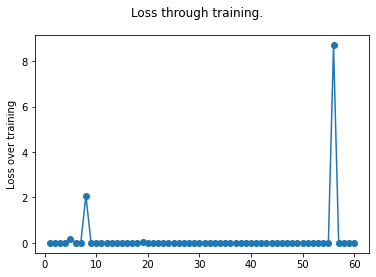

In [11]:
num_epochs = 5
def train(num_epochs, cnn, loaders, plot : bool = False):
    loss_list = []
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)#[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 10000 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                if plot:
                    loss_list.append(loss.item())
                
                pass
        pass
    
    if plot:
        xVals = list(range(1, len(loss_list) + 1))
        
        # subplots define number of rows and columns
        fig, ax1 = plt.subplots(1, 1)
        ax1.plot(xVals, loss_list, 'o-')
        fig.suptitle(f"Loss through training.")
        ax1.set_ylabel("Loss over training")
       
    print("Done!")            
    pass

train(num_epochs, model, loaders, True)

## Saving and loading model

### Saving

Here is quite a good [tutorial](https://pytorch.org/tutorials/beginner/saving_loading_models.html) for saving and loading models.

In [ ]:
path = "adversarial_numbies_model.pth"
torch.save(model.state_dict(), path)
print("Saved PyTorch Model State to model.pth")

### Load
Loading the model afterwards... quite an important part of the process.

In [ ]:
model = CNN().to(device)
model.load_state_dict(torch.load(path))

## FGSM Attack
(Fast Gradient Sign Method) Attack.
Here we define the function that creates the adversarial example by urbing the original image.

In [12]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

## Testing function
This is a testing function written by the peeps at pyTorch. It seems like it does a lot, I am not entirely sure what everything is though.

In [47]:
def test( model, device, test_loader, epsilon):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        # print(f"Output:\n{output}")
        init_pred = output.max(1, keepdim=True) # get the index of the max log-probability
        # print(f"Do we get this far?\n initial prediction: {init_pred}")
        init_pred_index = init_pred[1][0]
        # print(f"Do we get this far?\n initial prediction index: {init_pred_index}")
        

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred_index.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        # NOTE: Output with the way I (Felix) did it is a tuple, where second index
        # is stating that gradient is on... or something.
        # So I just extract the first index.
        # NOTE: THIS correction was a huge mistake.
        output = model(perturbed_data)
        # print(f"second output: {output}")

        # Check for success
        final_pred = output.max(1, keepdim=True) # get the index of the max log-probability
        final_pred_index = final_pred[1][0]
        #print(f"Final prediction indedx: {final_pred_index}")
        
        if final_pred_index.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred_index.item(), final_pred_index.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred_index.item(), final_pred_index.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

## Finally we run the attack
This also saves some values, so that we can see how the accuracy falls along with greater epsilon (error) rates.


In [48]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, loaders["test"], eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9792 / 10000 = 0.9792
Epsilon: 0.05	Test Accuracy = 8114 / 10000 = 0.8114
Epsilon: 0.1	Test Accuracy = 6125 / 10000 = 0.6125
Epsilon: 0.15	Test Accuracy = 4672 / 10000 = 0.4672
Epsilon: 0.2	Test Accuracy = 3773 / 10000 = 0.3773
Epsilon: 0.25	Test Accuracy = 3129 / 10000 = 0.3129
Epsilon: 0.3	Test Accuracy = 2681 / 10000 = 0.2681


## Results
We make an **accuracy** vs. **epsilon*** plot and see that there is a clear correlation.

### Accuracy vs. Epsilon

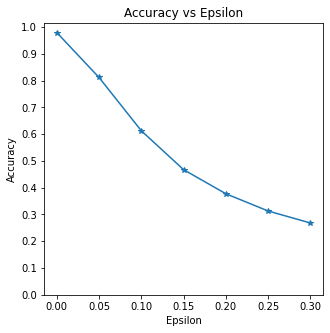

In [49]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

### Sample Adversarial Examples
Here we show some of the images that are the results of adversarial attacks, alongside the prediction by the network :) 

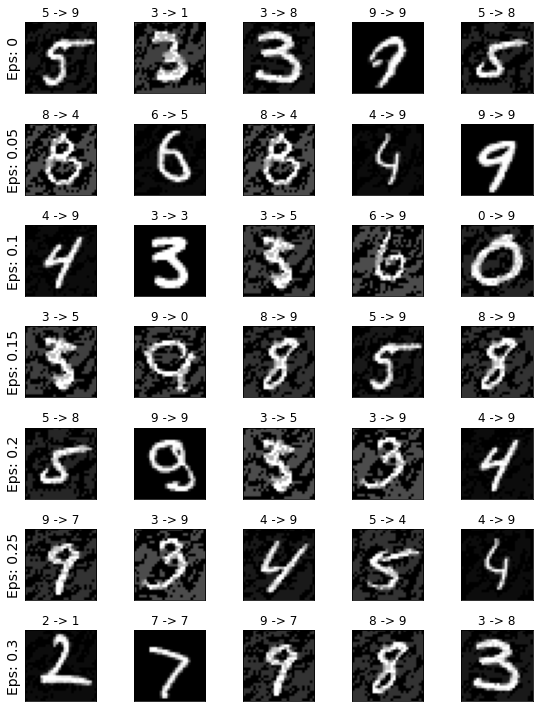

In [53]:
# Plot several examples of adversarial samples at each epsilon

cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [ ]:
loaders["test"]
i = 0
for data, target in loaders["test"]:
    output = model(data)
    print(f"output: {output}")
    print(f"First index: {output[0]}")
    print(f"Tensor shape: {data.shape}")
    if i == 3:
        break
    i += 1

output: tensor([[ 0.0367,  0.0091,  0.0380,  0.0301, -0.0774,  0.0019, -0.0473, -0.0533,
          0.0037,  0.0514]], grad_fn=<AddmmBackward0>)
First index: tensor([ 0.0367,  0.0091,  0.0380,  0.0301, -0.0774,  0.0019, -0.0473, -0.0533,
         0.0037,  0.0514], grad_fn=<SelectBackward0>)
Tensor shape: torch.Size([1, 1, 28, 28])
output: tensor([[-0.0142, -0.0071,  0.0135, -0.0021, -0.1071,  0.0344, -0.0496, -0.0222,
         -0.0198,  0.0369]], grad_fn=<AddmmBackward0>)
First index: tensor([-0.0142, -0.0071,  0.0135, -0.0021, -0.1071,  0.0344, -0.0496, -0.0222,
        -0.0198,  0.0369], grad_fn=<SelectBackward0>)
Tensor shape: torch.Size([1, 1, 28, 28])
output: tensor([[ 0.0028, -0.0023, -0.0216,  0.0151, -0.0971,  0.0463, -0.0593, -0.0422,
         -0.0013,  0.0501]], grad_fn=<AddmmBackward0>)
First index: tensor([ 0.0028, -0.0023, -0.0216,  0.0151, -0.0971,  0.0463, -0.0593, -0.0422,
        -0.0013,  0.0501], grad_fn=<SelectBackward0>)
Tensor shape: torch.Size([1, 1, 28, 28])
outp